<font size=10>Assignment 4

<font size=8>Introduction

<font size=4> Objective: Develop a comprehensive model of the Co-Zr-Cr-Ti quaternary system and assess its glass-forming capabilities through the utilization of Maximum Full Width at Half Maximum (MaxFWHM) measurements. The investigation will involve a thorough exploration of pertinent features, employing sophisticated featurization techniques, and implementing cross-validation methodologies to enhance the model's predictability in accordance with physical measurements.

<font size=8>Code

<font size=6>Modules

In [22]:
#Loading dependencies
import scipy.io
import numpy.matlib as nm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import sklearn
import pymatgen
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [23]:
#Versions used
print(pd.__version__) #1.5.3
print(np.__version__) #1.24.4
print(scipy.__version__) #1.12.0
print(sklearn.__version__) #1.2.1
print(pymatgen.__version__) #1.2.1

1.5.3
1.26.4
1.12.0
1.2.1


AttributeError: module 'pymatgen' has no attribute '__version__'

<font size=6>Importing data

In [24]:
# Load data from the same CSV file with different sheets
xls_file = pd.ExcelFile('Metallic Glass Data.xlsx')  # Update with your actual file name

# Read data from different sheets
CrTiZr_data = xls_file.parse('CrTiZr')
CrCoZr_data = xls_file.parse('CrCoZr')
CoTiZr_data = xls_file.parse('CoTiZr')

#add a string of the elements in the compound
CrTiZr_data['comp_string'] = 'CrTiZr'
CrCoZr_data['comp_string'] = 'CrCoZr'
CoTiZr_data['comp_string'] = 'CoTiZr'

In [25]:
#using function given in Practical #5 for plotting ternary diagrams

import ternary

def plot_ternary(data, components, z, label, title=''):
    
    fig, ax = plt.subplots()
    scale = 100

    grid = plt.GridSpec(10, 10, wspace=2, hspace=1)
    ax = plt.subplot(grid[:,:9])

    figure, tax = ternary.figure(scale=scale, ax=ax)
    # Draw Boundary and Gridlines
    tax.boundary(linewidth=2.0)
    tax.gridlines(color="red", multiple=10)

    # Set Axis labels and Title
    fontsize = 12
    offset = 0.14
    tax.right_corner_label(components[0], fontsize=fontsize, offset=0.2, fontweight='bold')
    tax.top_corner_label(components[2], fontsize=fontsize, offset=0.23, fontweight='bold')
    tax.left_corner_label(components[1], fontsize=fontsize, offset=0.2, fontweight='bold')
    tax.left_axis_label("at.%", fontsize=fontsize, offset=offset)
    tax.right_axis_label("at.%", fontsize=fontsize, offset=offset)
    tax.bottom_axis_label("at.%", fontsize=fontsize, offset=offset)
    tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025, clockwise= True)
    tax.get_axes().axis('off')
    tax.clear_matplotlib_ticks()

    
    
    # Create color map and plot color bar
    cmap = plt.cm.nipy_spectral
    norm = plt.Normalize(0, z.max())
    
    tax.scatter(data, marker='o', c=cmap(norm(z)), edgecolors='k', alpha=1, s=30, vmin=z.min(), vmax=z.max())
    
    ax = plt.subplot(grid[1:-1,9:])
    cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical', label=label)
    cb1.set_label(label=label, size=18)
    fig.suptitle(title,y=1,weight='bold')

Ternary system exploration

C:\Users\daves\AppData\Local\Temp\ipykernel_8456\2928094378.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(grid[:,:9])
c:\Users\daves\AppData\Local\Programs\Python\Python310\lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
C:\Users\daves\AppData\Local\Temp\ipykernel_8456\2928094378.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(grid[:,:9])
c:\Users\daves\AppData\Local\Programs\Python\Python310\lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs

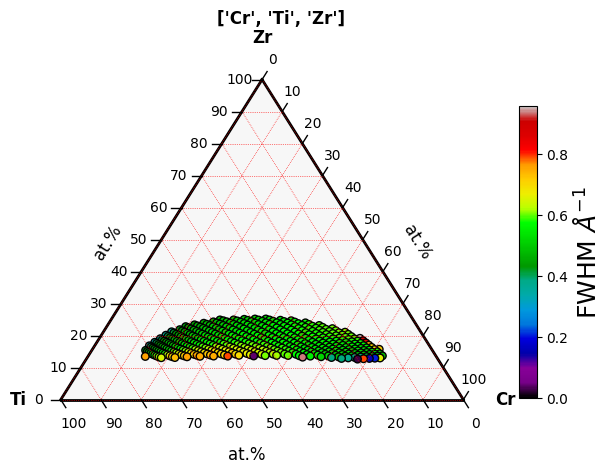

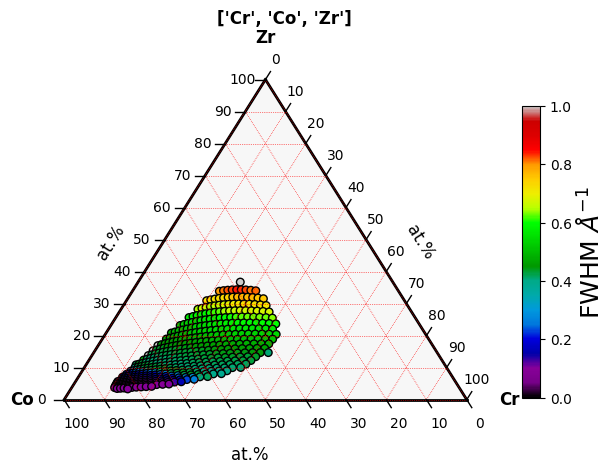

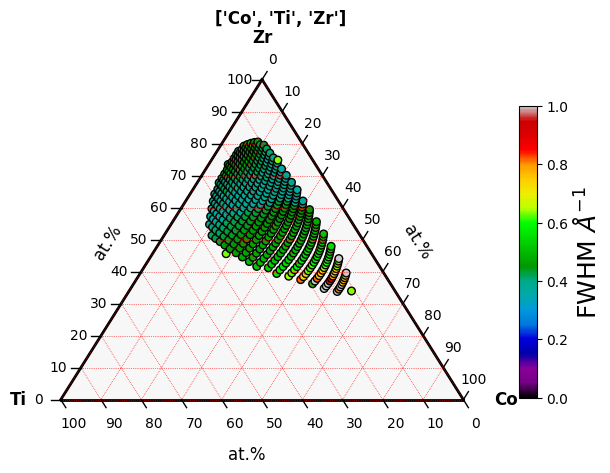

In [26]:
# Merge the ternary systems to create the quaternary system dataset

# a = cr , b = co , c =ti , d = zr
components = ['Cr','Co','Ti','Zr']
CoTiZr_components = [components[i] for i in [1,2,3]]
CrCoZr_components = [components[i] for i in [0,1,3]]
CrTiZr_components = [components[i] for i in [0,2,3]]

component_list = [CrTiZr_components,CrCoZr_components,CoTiZr_components]
data = [CrTiZr_data,CrCoZr_data,CoTiZr_data]

for c,d in zip(component_list,data):
    cmp =d.loc[:,c].to_numpy()
    cmp*=100
    points=nm.vstack((cmp[:,0].T,cmp[:,2].T)).T

    plot_ternary(points, c, d['MaxFWHM'], label='FWHM $\AA^{-1}$',title= f'{c}')

Bridge - Creating a quaternary dataframe

In [27]:
temp= pd.concat([CrTiZr_data.pop('MaxFWHM'), CrCoZr_data.pop('MaxFWHM'), CoTiZr_data.pop('MaxFWHM')],ignore_index=True)
quaternary_data = pd.merge(CrTiZr_data,CrCoZr_data,on=['Cr', 'Zr','comp_string'],how='outer')
quaternary_data = pd.merge(quaternary_data, CoTiZr_data, on=['Co', 'Ti', 'Zr','comp_string'],how='outer')
quaternary_data=pd.concat([quaternary_data,temp],axis=1)

Filling NaN values

In [28]:
#NanN values appear where element is missing, so 0 is a valid replacement
quaternary_data.fillna(0,inplace=True)

In [29]:
quaternary_data

,Cr,Ti,Zr,comp_string,Co,MaxFWHM
0,0.270945,0.480078,0.248976,CrTiZr,0.000000,0.491267
1,0.196268,0.575674,0.228059,CrTiZr,0.000000,0.427990
2,0.215384,0.550948,0.233668,CrTiZr,0.000000,0.455407
3,0.235852,0.525511,0.238637,CrTiZr,0.000000,0.470065
4,0.257642,0.499465,0.242892,CrTiZr,0.000000,0.480589
...,...,...,...,...,...,...
1318,0.000000,0.110050,0.373767,CoTiZr,0.516183,0.769533
1319,0.000000,0.104183,0.381011,CoTiZr,0.514806,0.744379
1320,0.000000,0.098608,0.388291,CoTiZr,0.513101,0.642379
1321,0.000000,0.093310,0.395614,CoTiZr,0.511076,1.000000


<font size=6>Featurize

Getting a matpygem composition value

In [30]:
import pymatgen.core

In [31]:
pymatgen.core.__version__

'2024.2.8'

In [32]:
#Conversion code modiffied from GPT 3.5 template

import pandas as pd
from pymatgen import core

# Apply the featurizer to each row of the DataFrame
compositions = []
for index, row in quaternary_data[components].iterrows():
    # Convert the row (elemental fractions) to a dictionary
    element_fractions = row.to_dict()
     # Convert the elemental fractions to a Pymatgen Composition object
    composition = core.Composition(element_fractions)
    # Append the features to the result list
    compositions.append(composition)
# Convert the result features list to a new DataFrame
compositions_df = pd.DataFrame(pd.Series(compositions,name='composition'))
quaternary_data_with_composition = pd.concat([quaternary_data, compositions_df],axis=1)


In [33]:
quaternary_data_with_composition

,Cr,Ti,Zr,comp_string,Co,MaxFWHM,composition
0,0.270945,0.480078,0.248976,CrTiZr,0.000000,0.491267,"(Cr, Ti, Zr)"
1,0.196268,0.575674,0.228059,CrTiZr,0.000000,0.427990,"(Cr, Ti, Zr)"
2,0.215384,0.550948,0.233668,CrTiZr,0.000000,0.455407,"(Cr, Ti, Zr)"
3,0.235852,0.525511,0.238637,CrTiZr,0.000000,0.470065,"(Cr, Ti, Zr)"
4,0.257642,0.499465,0.242892,CrTiZr,0.000000,0.480589,"(Cr, Ti, Zr)"
...,...,...,...,...,...,...,...
1318,0.000000,0.110050,0.373767,CoTiZr,0.516183,0.769533,"(Co, Ti, Zr)"
1319,0.000000,0.104183,0.381011,CoTiZr,0.514806,0.744379,"(Co, Ti, Zr)"
1320,0.000000,0.098608,0.388291,CoTiZr,0.513101,0.642379,"(Co, Ti, Zr)"
1321,0.000000,0.093310,0.395614,CoTiZr,0.511076,1.000000,"(Co, Ti, Zr)"


featurzing with magpie

In [34]:
import matminer

In [35]:
matminer.__version__

'0.9.0'

In [37]:
#Template modified from lecture 5 slides

from matminer.featurizers.composition import composite as comp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)#stack overflow "https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning"

features = [ "Number", "MendeleevNumber", "AtomicWeight", "MeltingT",  "Column", "Row", "CovalentRadius", "Electronegativity", "NsValence", "NpValence", "NdValence", "NfValence", "NValence", "NsUnfilled", "NpUnfilled", "NdUnfilled", "NfUnfilled", "NUnfilled","GSvolume_pa", "GSbandgap", "GSmagmom"]
stats = ["mean", "avg_dev", "minimum", "maximum", "range"]
magpie = comp.ElementProperty('magpie', features, stats) 
features_df = pd.DataFrame()
for row in range(len(quaternary_data_with_composition)):
    feature = magpie.featurize(quaternary_data_with_composition['composition'][row])
    features_df = features_df.append(pd.Series(feature),ignore_index=True)
quaternary_data_featurized = pd.concat([quaternary_data_with_composition,features_df],axis=1)
    
    


ValueError: Unexpected atomic number Z=119

In [ ]:
quaternary_data_featurized.head()

NameError: name 'quaternary_data_featurized' is not defined

<font size=6>CV

Loco

Creating a test and train split of the featurized data set

In [ ]:
#creating a index map of where certain compositions are found
elements = ['Cr',#will represent 'CoTiZr'
            'Co',#will represent 'CrTiZr'
            'Ti']#will represent 'CrCoZr'
#creating a matrix
id_acta={}
for i in elements:
    id_acta[i] = quaternary_data_featurized[i] == 0
#id__acta identifies where there are no values for a certain element. ie reprecents where a certain ternary is

NameError: name 'quaternary_data_featurized' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

#separating features from target columns
#Y = quaternary_data_featurized.pop('MaxFWHM')
#q_train , q_test = model_selection.ShuffleSplit.split(n_splits = 1,test_size=0.2)

TypeError: BaseShuffleSplit.split() got an unexpected keyword argument 'n_splits'

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit#function addapted from Lecture 5 slides

def split_by_chemical_omission(df,id_acta=None, test_size=0.15, verbose=True):
    cv = StratifiedShuffleSplit(n_splits=1, test_size=test_size,random_state=0)
    for train, test in cv.split(df,df['comp_string']):
        if verbose:
            print(f"Training data points: {len(train)}")
            print(f"Test data points: {len(test)}")
            print(f"total points:{len(train)+len(test)}")
    return train,test

In [ ]:
train,test =split_by_chemical_omission(quaternary_data_featurized)

Training data points: 1124
Test data points: 199
total points:1323


In [ ]:
quaternary_data_featurized.iloc[train]['comp_string'].value_counts()



CrCoZr    375
CrTiZr    375
CoTiZr    374
Name: comp_string, dtype: int64

In [ ]:
quaternary_data_featurized.iloc[test]['comp_string'].value_counts()

CoTiZr    67
CrCoZr    66
CrTiZr    66
Name: comp_string, dtype: int64

In [ ]:
train_CrTiZr,test_CrTiZr = split_by_chemical_omission(X_train,id_acta['Co'])
train_CoTiZr,test_CoTiZr = split_by_chemical_omission(X_train,id_acta['Cr'])
train_CrCoZr,test_CrCoZr = split_by_chemical_omission(X_train,id_acta['Ti'])

Training data points: 559
Test data points: 140
total points:699
Training data points: 572
Test data points: 143
total points:715
Training data points: 561
Test data points: 141
total points:702


In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(train_CrTiZr,test_CrTiZr)

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier

# Assuming X and y are your feature matrix and target variable
X, y = ...

# Assuming you have custom training data sets acting as folds (e.g., list of indices for each fold)
custom_folds = [([train_indices], [test_indices]) for train_indices, test_indices in your_custom_folds]

# Create a classifier (Random Forest, for example)
clf = RandomForestClassifier()

# Use custom cross-validation splitter
custom_cv = KFold(n_splits=len(custom_folds), shuffle=False)

# Use cross_val_score for performance evaluation with custom folds
scores = cross_val_score(clf, X, y, cv=custom_cv, scoring='accuracy')

# Print the scores for each fold
for i, score in enumerate(scores):
    print(f"Fold {i + 1}: {score}")


random

standardization

train

temp

predict

evaluate

summarize

In [ ]:

# Define features (X) and target variable (y) for linear regression
X = quaternary_data[['A', 'B', 'C', 'D']]
y = quaternary_data['Output']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the target variable for the test set
y_pred = model.predict(X_test)

# Evaluate the model performance (you can choose other metrics)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Predict the quaternary system values
quaternary_prediction = model.predict(X)

# Create a DataFrame for the predicted quaternary system
quaternary_prediction_df = pd.DataFrame(
    data=quaternary_prediction,
    columns=['Predicted_Output']
)

# Print the predicted quaternary system
print(quaternary_prediction_df)


KeyError: "None of [Index(['A', 'B', 'C', 'D'], dtype='object')] are in the [columns]"